# Hyperparameter tuning

now it's time to tune our models by changing hyperparameters

## import libs

In [22]:
import re
import string
from abc import ABC

from nltk.corpus import stopwords

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

## import models, input providers and other codes

In [44]:
from input_providers import *
from metrics import MetricsCalculator
from models import *
from workflow import TrainValidationWorkflow
from report import report

## train, validation and test data sets split

In [24]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/train.csv')
random_state_seed = 22
df_train_validation, df_test = train_test_split(df, test_size=0.2, random_state=random_state_seed)
df_train, df_validation = train_test_split(df_train_validation, test_size=0.25, random_state=random_state_seed)

In [25]:
input_providers = [InputProvider1(), InputProvider2(), InputProvider3(), InputProvider4(), InputProvider5()]

## hyperparameter tuning of Logistic regression model 
the important hyperparameters to tune for `sklearn.linear_model.LogisticRegression` include:
- `C`: inverse of the regularization strength
- `solver`
- `max_iter`

#### optimize inverse of the regularization strength

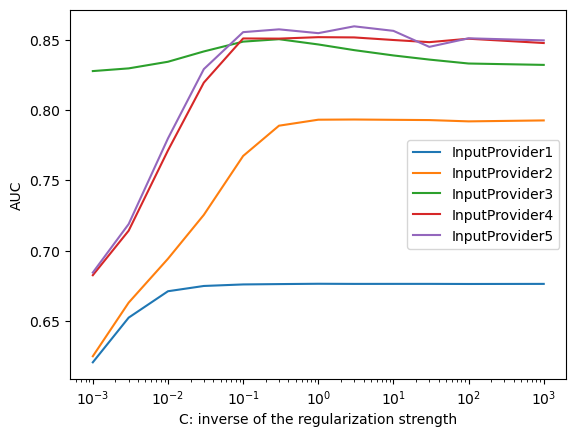

In [26]:
performance = dict()
c_range = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 1000]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for c in c_range:
        metrics = TrainValidationWorkflow(
            model=LogisticRegressionModel(C=c, random_state=random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

for key, value in performance.items():
    plt.semilogx(c_range, value, label=key)
    plt.xlabel('C: inverse of the regularization strength')
    plt.ylabel('AUC')
    plt.legend()

c=0.1 seems to be a good number for all input providers

#### optimize solver
sklearn logistic regression has various solvers:
1. newton-cg: This solver uses a modified Newton's method to solve the optimization problem. It is recommended for datasets with a small number of samples and features.
2. lbfgs: This solver uses the Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm to solve the optimization problem. It is recommended for datasets with a small number of samples and features.
3. liblinear: This solver uses a coordinate descent algorithm to solve the optimization problem. **It is recommended for datasets with a large number of samples and features.**
4. sag: This solver uses a stochastic average gradient descent algorithm to solve the optimization problem. **It is recommended for datasets with a large number of samples and features.**
5. saga: This solver uses a variant of the stochastic average gradient descent algorithm to solve the optimization problem. **It is recommended for datasets with a large number of samples and features.**

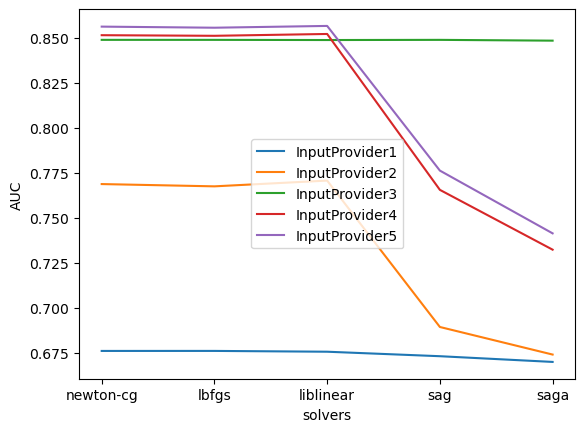

In [27]:
performance = dict()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for solver in solvers:
        metrics = TrainValidationWorkflow(
            model=LogisticRegressionModel(C=0.1, solver=solver, random_state=random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

for key, value in performance.items():
    plt.plot(solvers, value, label=key)
    plt.xlabel('solvers')
    plt.ylabel('AUC')
    plt.legend()

liblinear seems to be a good model here

## optimize max_iter

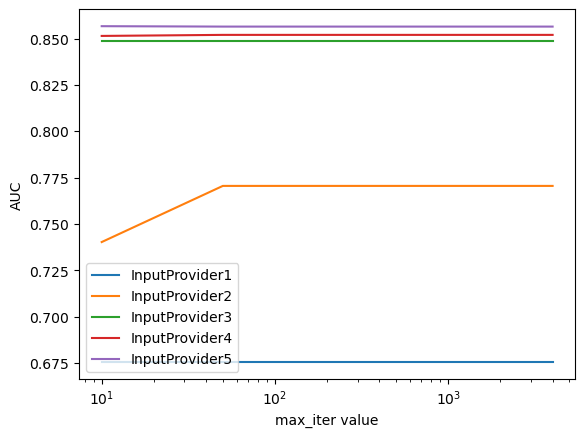

In [29]:
performance = dict()
max_iterations = [10, 50, 100, 200, 500, 1000, 2000, 4000]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for max_iter in max_iterations:
        metrics = TrainValidationWorkflow(
            model=LogisticRegressionModel(C=0.1, solver='liblinear', max_iter=max_iter, random_state=random_state_seed),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

for key, value in performance.items():
    plt.semilogx(max_iterations, value, label=key)
    plt.xlabel('max_iter value')
    plt.ylabel('AUC')
    plt.legend()

we would use the default value for max_iter which is 100
finally our model is this:

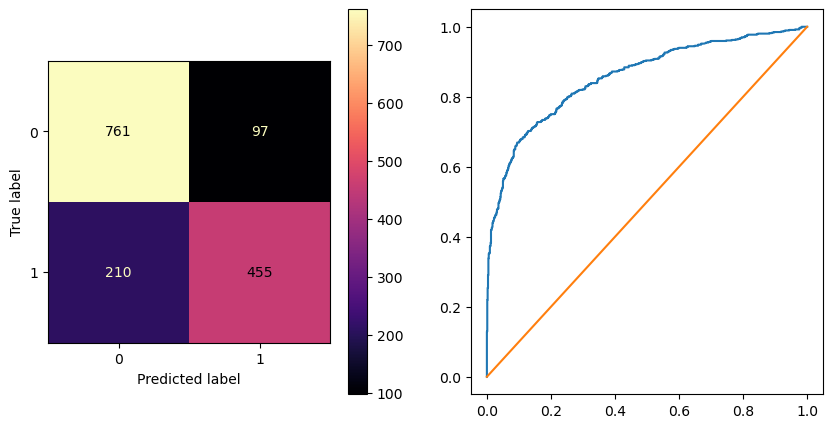

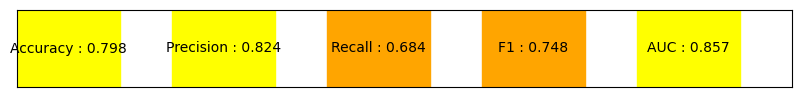

In [45]:
report(TrainValidationWorkflow(
    model=LogisticRegressionModel(C=0.1, solver='liblinear', random_state=random_state_seed),
    input_provider=InputProvider5(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

## hyperparameter tuning of Decision Tree model 
the important hyperparameters to tune for `sklearn.tree.DecisionTreeClassifier` include:
1. `max_depth`
2. `min_samples_leaf`

#### tuning max_depth

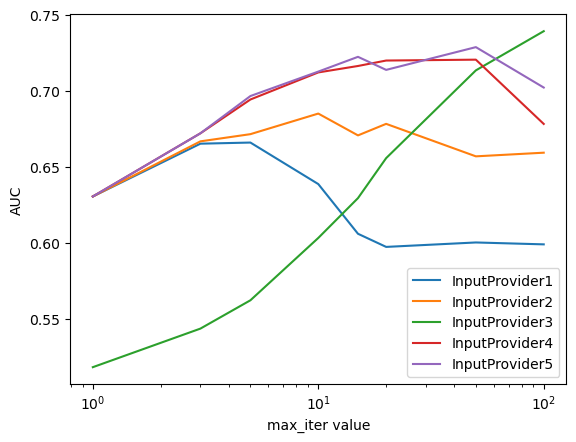

In [30]:
performance = dict()
depths = [1, 3, 5, 10, 15, 20, 50, 100, 200, 500, 1000, None]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for depth in depths:
        metrics = TrainValidationWorkflow(
            model=DecisionTreeModel(max_depth=depth),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

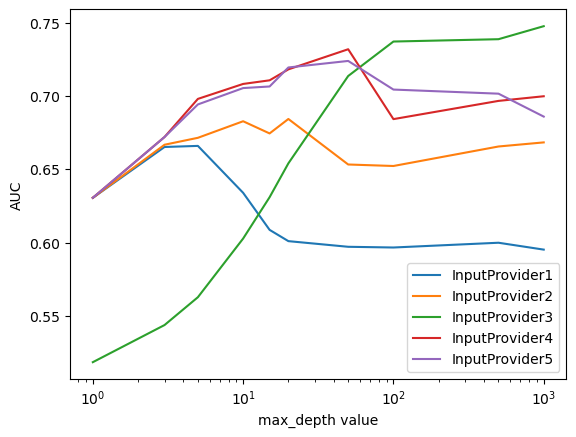

In [33]:
for key, value in performance.items():
    plt.semilogx(depths, value, label=key)
    plt.xlabel('max_depth value')
    plt.ylabel('AUC')
    plt.legend()

the optimum value of max_depth is different for each input_provider (which makes sense)

| input provider number | number of features | optimum value for `max_iter` |
|-----------------------|--------------------|------------------------------|
| 1                     | 7                  | 4                            |
| 2                     | 229                | 20                           |
| 3                     | 15699              | None                         | 
| 4                     | 15707              | 50                           |
| 5                     | 15929              | 50                           |

let's skip this for a second and check max_leaf_nodes

#### tuning min_samples_leaf

In [38]:
performance = dict()
leaf_range = [1, 5, 10, 15, 20, 50, 100, 200]

for input_provider in input_providers:
    performance[input_provider.__class__.__name__] = []
    for leaf in leaf_range:
        metrics = TrainValidationWorkflow(
            model=DecisionTreeModel(min_samples_leaf=leaf),
            input_provider=input_provider,
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()

        performance[input_provider.__class__.__name__].append(metrics.get_auc())

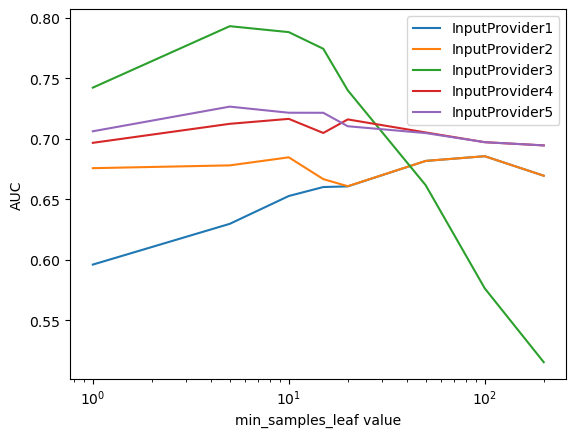

In [40]:
for key, value in performance.items():
    plt.semilogx(leaf_range, value, label=key)
    plt.xlabel('min_samples_leaf value')
    plt.ylabel('AUC')
    plt.legend()

the optimum value of min_samples_leaf is different for each input_provider

| input provider number | number of features | optimum value for `max_iter` |
|-----------------------|--------------------|------------------------------|
| 1                     | 7                  | 100                          |
| 2                     | 229                | 100                          |
| 3                     | 15699              | 5                            | 
| 4                     | 15707              | 10                           |
| 5                     | 15929              | 5                            |

the best AUC was archived using 3rd input provider. so lets this input provider constant and change the min_samples_leaf and max_depth

In [41]:
performance = []
depths = [1, 3, 5, 10, 15, 20, 50, 100, 200, 500, 1000, None]
leaf_range = [1, 5, 10, 15, 20, 50, 100, 200]

for depth in depths:
    perf = []
    for leaf in leaf_range:
        metrics = TrainValidationWorkflow(
            model=DecisionTreeModel(min_samples_leaf=leaf, max_depth=depth),
            input_provider=InputProvider3(),
            df_train=df_train,
            df_validation=df_validation
        ).get_metrics_calculator()
        
        perf.append(metrics.get_auc())
    performance.append(perf)

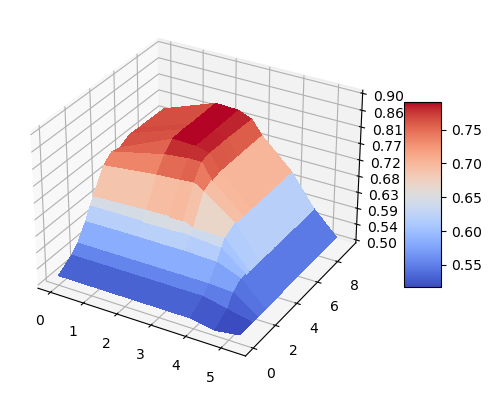

In [80]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
y = [1, 3, 5, 10, 15, 20, 50, 100, 200, 500, 1000, 10000]
x = [1, 5, 10, 15, 20, 50, 100, 200]
x = np.log(x)
y = np.log(y)
x, y = np.meshgrid(x, y)
z = np.array(performance)


# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.5, 0.9)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [99]:
result = pd.DataFrame(data=performance, columns=leaf_range, index=depths)
row, col = np.where(result == result.max().max())
print(result.max().max())
result

0.794131307289202


,1,5,10,15,20,50,100,200
1.0,0.518383,0.518383,0.518383,0.518383,0.518383,0.518383,0.506543,0.515528
3.0,0.543724,0.543812,0.543812,0.543812,0.543745,0.543729,0.529338,0.515528
5.0,0.562707,0.562941,0.562932,0.562886,0.562838,0.562951,0.558686,0.515528
10.0,0.602862,0.604372,0.603598,0.604283,0.604194,0.600910,0.576541,0.515528
15.0,0.634937,0.636003,0.637390,0.637208,0.634318,0.627125,0.576541,0.515528
20.0,0.652031,0.658598,0.659985,0.659764,0.646776,0.645566,0.576541,0.515528
50.0,0.713640,0.729762,0.733596,0.737392,0.720498,0.661707,0.576541,0.515528
100.0,0.733477,0.766620,0.773710,0.773782,0.732777,0.661707,0.576541,0.515528
200.0,0.727211,0.790675,0.788636,0.780065,0.740208,0.661707,0.576541,0.515528
500.0,0.742528,0.794131,0.788781,0.779086,0.740208,0.661707,0.576541,0.515528


the best hyperparameters are **max_depth=500** and **min_samples_leaf=5**
therefore the best model is:

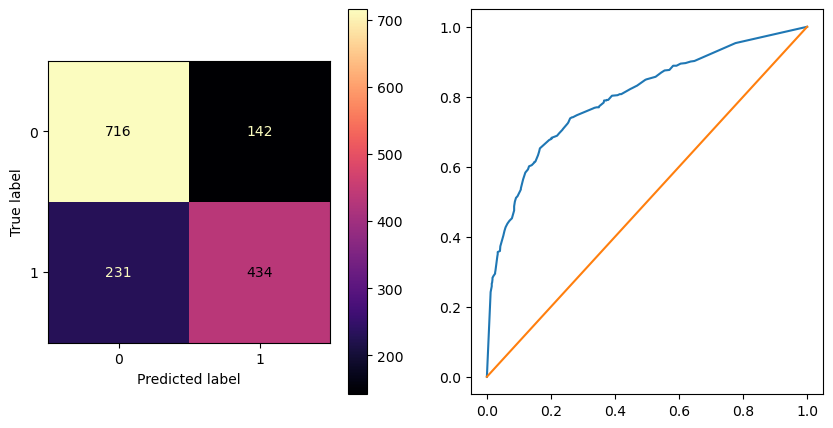

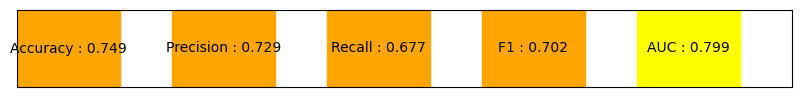

In [100]:
report(TrainValidationWorkflow(
    model=DecisionTreeModel(max_depth=500, min_samples_leaf=5, random_state=random_state_seed),
    input_provider=InputProvider3(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

the important hyperparameters to tune for `sklearn.ensemble.RandomForestClassifier` include:
1. `n_estimators`
2. `max_depth`
3. `max_leaf_nodes`

the important hyperparameters to tune for `sklearn.ensemble.GradientBoostingClassifier` include:
1. `max_iter`
2. `learning_rate`
3. `max_depth`

the important hyperparameters to tune for `xgboost` include:
1. `num_boost_round`
2. `eta`: Learning rate
3. `max_depth`
4. `min_child_weight`